### Load Packages
We need basic packages, intake (for catalogs) and healpix 
Make sure you have the hackathon environment installed. (This may be node specific. Please check with your local host.)

In [1]:
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import warnings

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
#import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import healpy


def get_nest(ds):
    return ds.crs.healpix_order == "nest"

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

### Load the catalog
We have one data catalog for the global hackathon, listing our datasets.
But as we have multiple hosting sites, which have some datasets available locally and can access other datasets remotely, the best way to access data may be dependent on the location **where analysis code is executed**.
To solve this issue, we have one sub-catalog per hackathon node (the site where analysis code is executed), and an additional `online` catalog, which is available from the public internet. Here's how you can see our currently available sub-catalogs:

In [2]:
list(intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"))

['CN', 'EU', 'JAPAN', 'NCAR', 'NERSC', 'UK', 'online']

In normal operation, you would **not** want to load this entire top-level catalog, but instead directly select the catalog appropriate for your location:

In [3]:
current_location = "EU"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

### List Catalog
list the sources in the catalog:

In [4]:
list (cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco2559_rcbmf',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### Pick a Data Set
Use `.describe()` on a dateset to see the other parameter options (we use `pandas` just for concise output formatting)

In [5]:
import pandas as pd

pd.DataFrame(cat["icon_d3hp003"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H, PT6H, P1D]",P1D
1,time_method,time subsetting method,str,"[mean, inst]",mean
2,zoom,zoom resolution of the dataset,int,"[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


### Load Data into a Data Set
most datasets have a `zoom` parameter. We will use `zoom` level 7 [(~50km)](https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution)

In [6]:
ds = cat["icon_d3hp003"](zoom=8).to_dask() 
ds

<xarray.Dataset> Size: 392GB
Dimensions:        (time: 425, cell: 786432, crs: 1, pressure: 30,
                    soil_level: 5, pressure_rva: 3)
Coordinates:
  * crs            (crs) float32 4B nan
  * pressure       (pressure) int64 240B 5 10 20 50 ... 92500 95000 97500 100000
  * pressure_rva   (pressure_rva) int64 24B 16 18 23
  * soil_level     (soil_level) int64 40B 0 0 0 2 6
  * time           (time) datetime64[ns] 3kB 2020-01-02 ... 2021-03-01
Dimensions without coordinates: cell
Data variables: (12/58)
    clivi          (time, cell) float32 1GB ...
    clt            (time, cell) float32 1GB ...
    clwvi          (time, cell) float32 1GB ...
    egpvi          (time, cell) float32 1GB ...
    einvi          (time, cell) float32 1GB ...
    ekhvi          (time, cell) float32 1GB ...
    ...             ...
    ua             (time, pressure, cell) float32 40GB ...
    uas            (time, cell) float32 1GB ...
    va             (time, pressure, cell) float32 40GB ...
    vas            (time, cell) float32 1GB ...
    wa             (time, pressure, cell) float32 40GB ...
    zg             (time, pressure, cell) float32 40GB ...
Attributes:
    hiopy::parent:  P1D_mean_z9_atm

### Plot data on a map

See the [plotting with cartopy example of easy.gems for more details](https://easy.gems.dkrz.de/Processing/healpix/healpix_cartopy.html).

<Figure size 640x480 with 0 Axes>

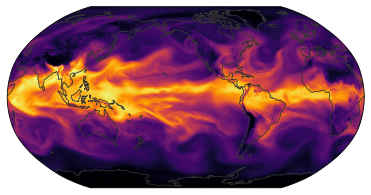

In [7]:
egh.healpix_show(ds["prw"].sel(time="2020-05-10T00:00:00"), cmap="inferno", dpi=72);

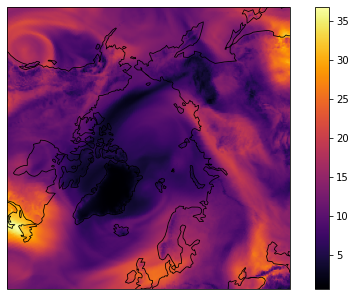

In [8]:
map_extent = [-65, -5, -10, 25]
projection = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
m=egh.healpix_show(ds["prw"].sel(time="2020-05-10T00:00:00"), ax=ax, cmap="inferno", dpi=72);
ax.add_feature(cf.COASTLINE, linewidth=0.8)
plt.colorbar(m)

### Plot a Zonal Mean

See [Time space diagrams on easy.gems for more info on selecting regions and grouping by lat/lon](https://easy.gems.dkrz.de/Processing/healpix/time-space.html).

Best to do this at lower resolution to reduce data volumes. Always take the lowest resolution that does the job. If in doubt, start with `zoom=0` and work your way up. Low zoom levels are fast to load and plot.

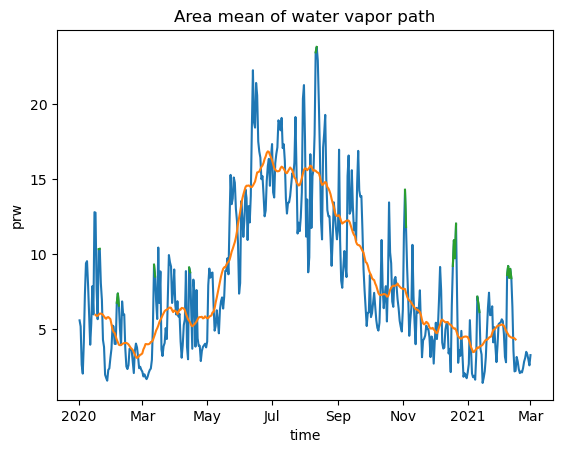

In [9]:
ds = cat["icon_d3hp003"](zoom=8).to_dask() 
# For this analysis, we'll need lat and lon coordinates, here's a way to attach them to the dataset:
ds = ds.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds.dims else ds.pipe(egh.attach_coords)

# define box over which prw will be averaged for a time series
lon_min=345
lon_max=15
lat_min=73
lat_max=77

#threshold ratio to the 30-day running mean above which we identify an event as moist intrusion
threshold_mi=1.5

var="prw"
long_name = ds[var].attrs.get("long_name", var)

zm = (
    ds[var]
    .where((ds['lon']<lon_max) |(ds['lon']>lon_min) )
    .groupby("lat")
    .mean()
).compute()

# compute lat-weighted area mean 

boxmean=zm.where((zm.lat>lat_min) & (zm.lat<lat_max)).weighted(np.cos(np.deg2rad(zm.lat))).mean(dim='lat')

boxmean.plot()
boxmean.rolling(time=30,center=True).mean().plot()

mi_mask=boxmean>(threshold_mi*boxmean.rolling(time=30,center=True).mean())
boxmean.where(mi_mask).plot()


nt=zm.time.shape[0]
#plt.plot(zm.time,15*np.sin(np.pi*2*(np.arange(0,nt)-100)/365))
plt.title(f"Area mean of {long_name}");

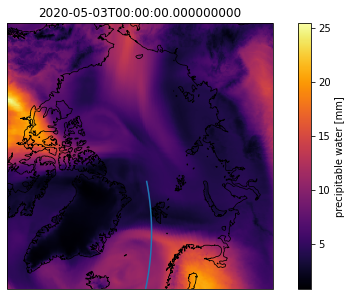

In [25]:
map_extent = [-65, -5, -10, 25]
projection = ccrs.NorthPolarStereo()

t='2020-05-03T00:00:00.000000000'

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
m=egh.healpix_show(ds["prw"].sel(time=t), ax=ax, cmap="inferno", dpi=72);
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.set_title(t)
plt.plot(lons_mi_t[15],lats_mi_t[15],transform=ccrs.PlateCarree())
plt.colorbar(m,label='precipitable water [mm]')

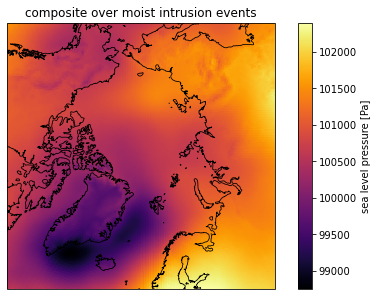

In [50]:
map_extent = [-65, -5, -10, 25]
projection = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
m=egh.healpix_show(ds["psl"].where(mi_mask).mean(dim='time'), ax=ax, cmap="inferno", dpi=72);
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.set_title('composite over moist intrusion events')
plt.colorbar(m,label='sea level pressure [Pa]')

In [11]:
#timesteps of identified moist intrusion events
ds['time'][mi_mask]

<xarray.DataArray 'time' (time: 40)> Size: 320B
array(['2020-01-17T00:00:00.000000000', '2020-01-20T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-11T00:00:00.000000000', '2020-03-12T00:00:00.000000000',
       '2020-03-13T00:00:00.000000000', '2020-03-16T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-26T00:00:00.000000000',
       '2020-04-14T00:00:00.000000000', '2020-04-15T00:00:00.000000000',
       '2020-04-18T00:00:00.000000000', '2020-05-03T00:00:00.000000000',
       '2020-05-23T00:00:00.000000000', '2020-06-13T00:00:00.000000000',
       '2020-08-11T00:00:00.000000000', '2020-08-12T00:00:00.000000000',
       '2020-09-20T00:00:00.000000000', '2020-10-12T00:00:00.000000000',
       '2020-10-19T00:00:00.000000000', '2020-11-03T00:00:00.000000000',
       '2020-11-04T00:00:00.000000000', '2020-11-10T00:00:00.000000000',
       '2020-12-06T00:00:00.000000000', '2020-12-18T00:00:00.000000000',
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
       '2021-01-11T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-01-21T00:00:00.000000000', '2021-02-07T00:00:00.000000000',
       '2021-02-08T00:00:00.000000000', '2021-02-09T00:00:00.000000000',
       '2021-02-10T00:00:00.000000000', '2021-02-11T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 320B 2020-01-17 2020-01-20 ... 2021-02-11
    crs      int64 8B 0
Attributes:
    axis:     T

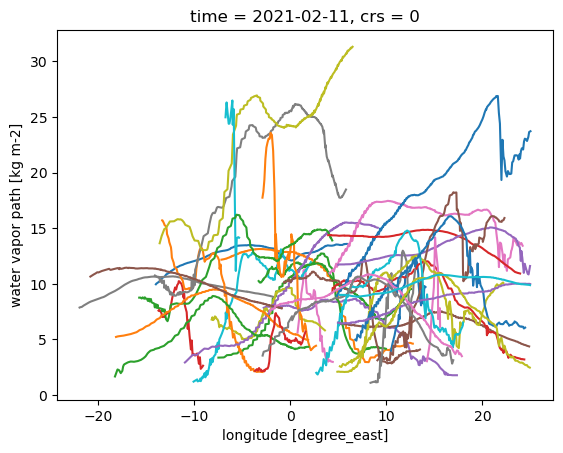

In [44]:
#
#lonse = np.linspace(0.0, 20.0, 200)
#lonsw=np.linspace(330.0,360.0,300)
#lons=np.concat([lonsw,lonse])
lons= np.linspace(-15, 15.0, 200)
lats = np.full_like(lons, 75.0)

pcore=85000

ds8 = cat["icon_d3hp003"](zoom=10).to_dask() 
ds8 = ds8.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds8.dims else ds8.pipe(egh.attach_coords)
ds8['lon']=ds8['lon'].where(cond=ds8['lon']<180,other=ds8['lon']-360)


pnts = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons, lats, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
    )

maxlon=[]
for t in ds['time'][mi_mask]: 

    maxlon_t=ds8.prw.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").argmax()
    ucore=ds8.ua.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    vcore=ds8.va.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    maxlon.append(maxlon_t)
    
    lons_t=np.linspace(ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values-10,ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values+10,200)
    lats_t=75-(ucore.values/vcore.values)*(lons_t-ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values)
    lons_t=lons_t[((lats_t>60)&(lats_t<85))]
    lats_t=lats_t[((lats_t>60)&(lats_t<85))]
    
    
    pnts_t = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons_t, lats_t, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons_t), "lat": (("cell",), lats_t)},
    )
    
    
    ds8.prw.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").plot(x="lon")
    #ds8.lat.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sortby("lon").plot(x="lon")
    
    

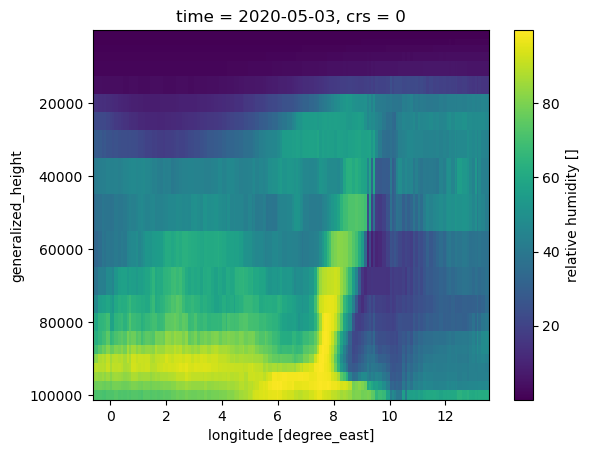

In [47]:
# plot relative humidity cross sections

nplots=mi_mask.sum().values

# initial cross-section to find prw maximum 
lons= np.linspace(-15, 15.0, 200)
lats = np.full_like(lons, 75.0)

#pressure level at which the moist intrusion core will be defined 
pcore=85000

ds8 = cat["icon_d3hp003"](zoom=10).to_dask() 
ds8 = ds8.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds8.dims else ds8.pipe(egh.attach_coords)
ds8['lon']=ds8['lon'].where(cond=ds8['lon']<180,other=ds8['lon']-360)


pnts = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons, lats, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
    )

maxlon=[]
lons_mi_t=[]
lats_mi_t=[]
#for t in ds['time'][mi_mask][:nplots]: # use this to plot all identified events 
for t in ['2020-05-03T00:00:00.000000000']: #plot selected example only 

    maxlon_t=ds8.prw.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").argmax()
    ucore=ds8.ua.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    vcore=ds8.va.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    maxlon.append(maxlon_t)
    
    lons_t=np.linspace(ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values-10,ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values+10,200)
    lats_t=75-(ucore.values/vcore.values)*(lons_t-ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values)
    lons_t=lons_t[((lats_t>60)&(lats_t<85))]
    lats_t=lats_t[((lats_t>60)&(lats_t<85))]
    lons_mi_t.append(lons_t)
    lats_mi_t.append(lats_t)
    
    pnts_t = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons_t, lats_t, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons_t), "lat": (("cell",), lats_t)},
    )
    
    
    ds8.hur.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").plot(x="lon", yincrease=False)
    #plt.figure()

plt.savefig('/home/a/a270082/hackathon/rh_crosssection_20200503.png')
    

/tmp/ipykernel_3226734/297402010.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


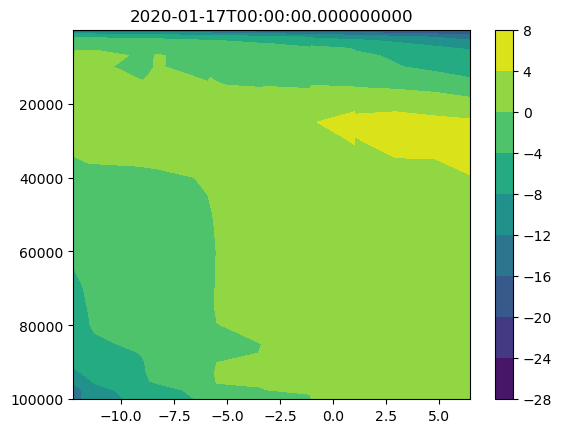

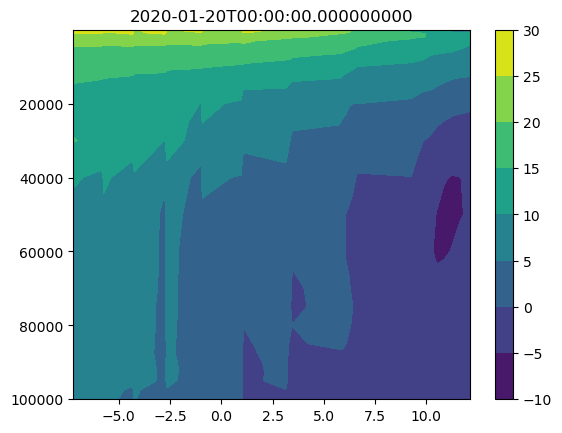

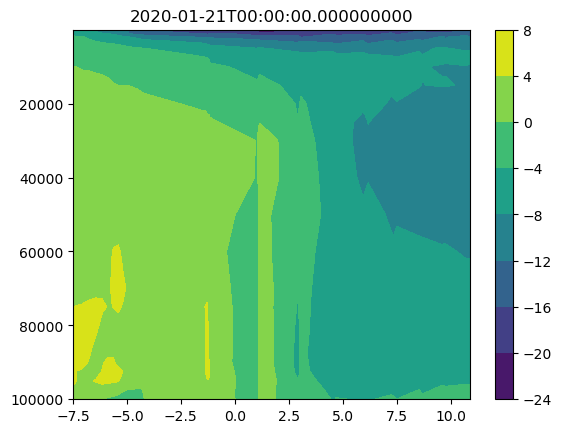

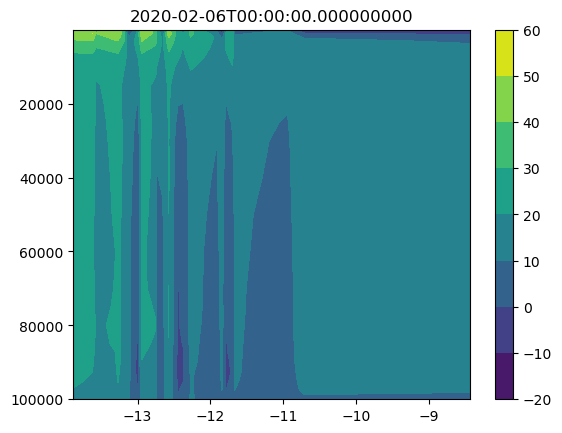

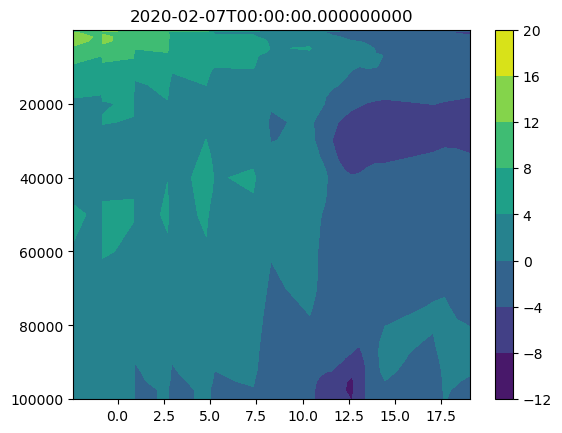

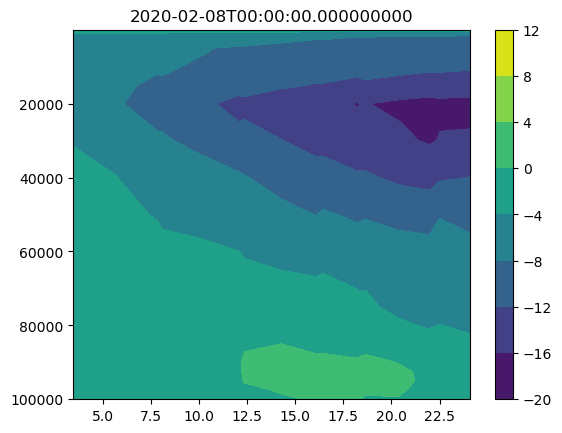

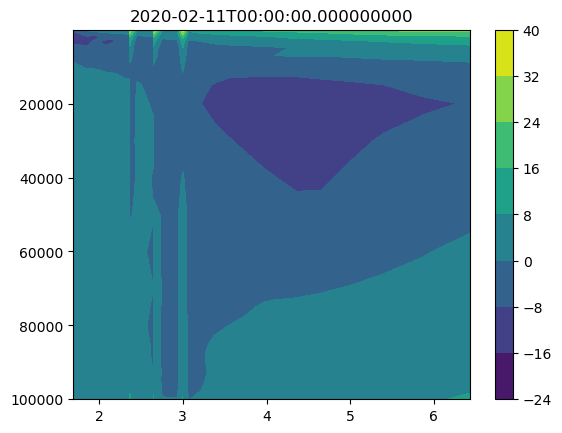

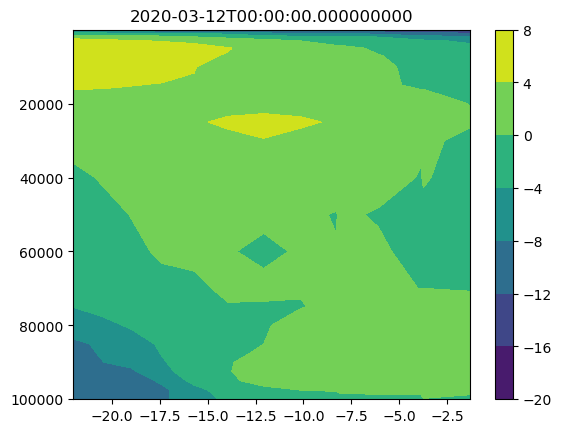

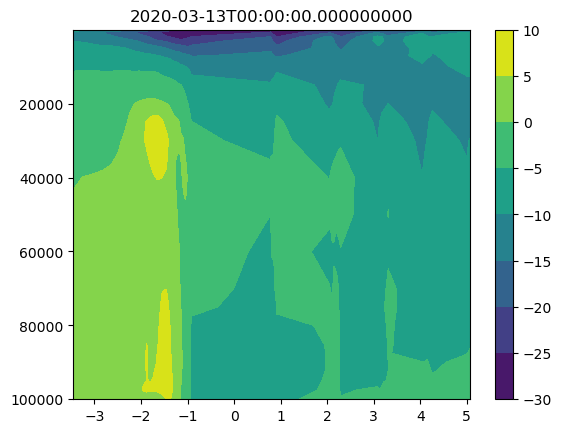

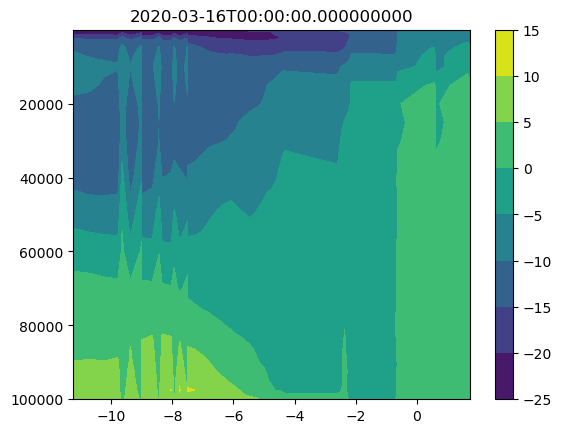

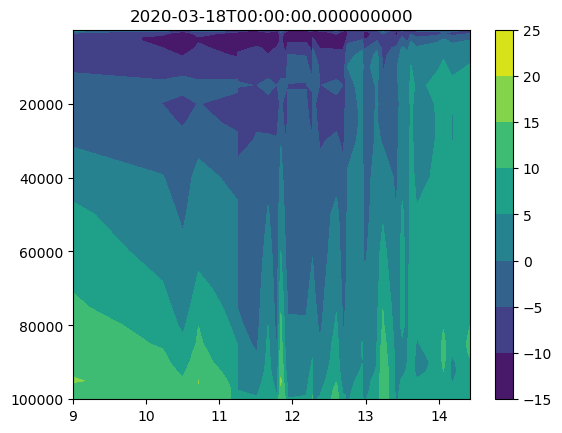

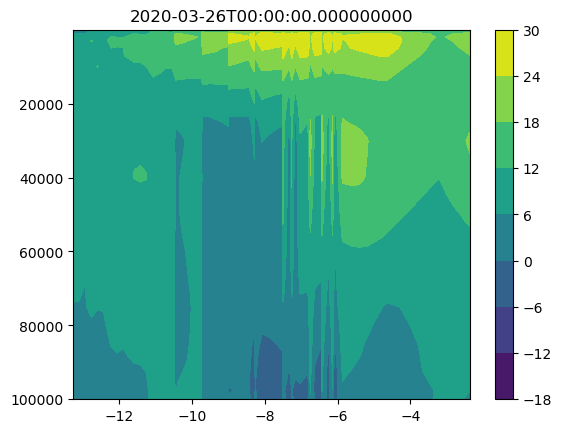

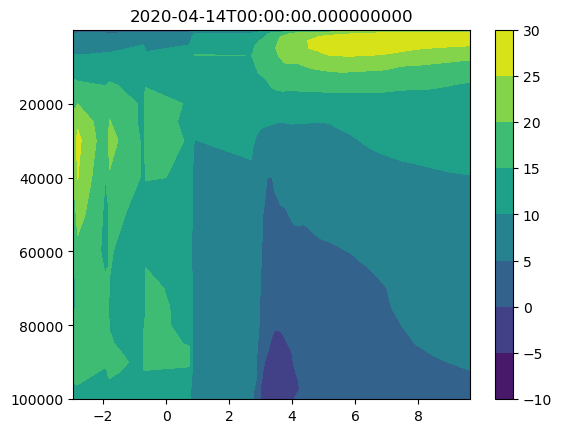

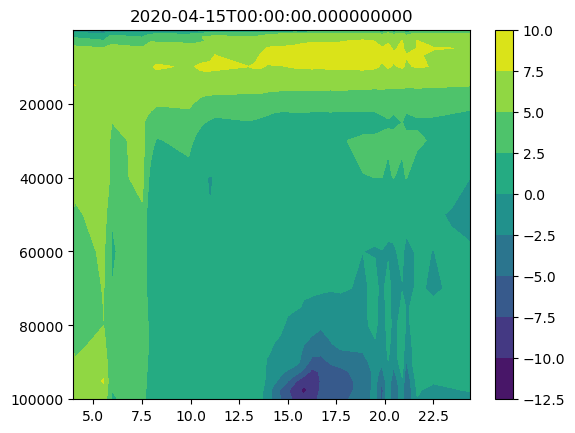

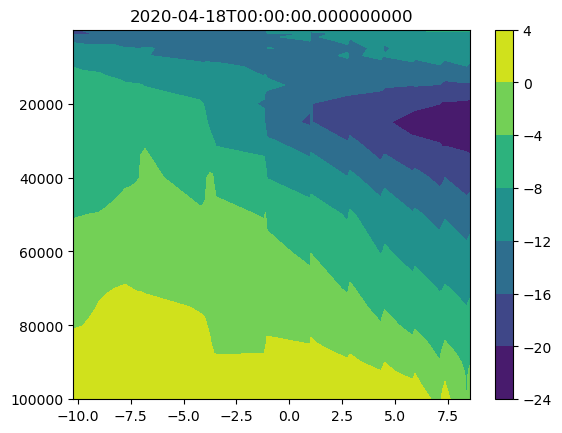

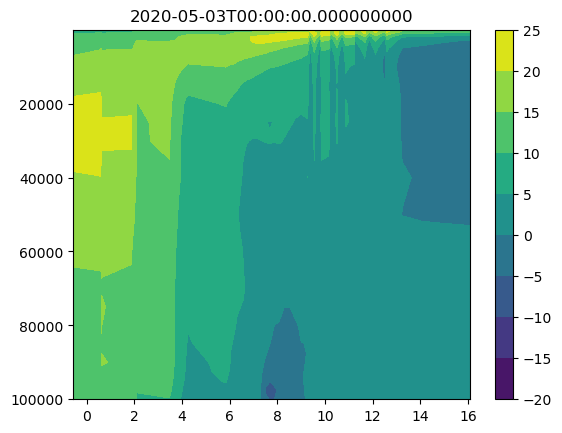

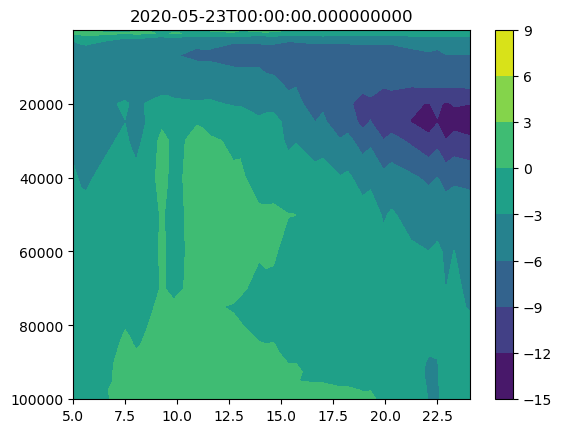

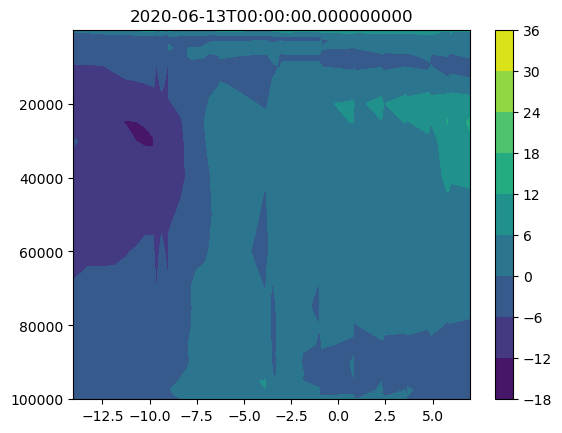

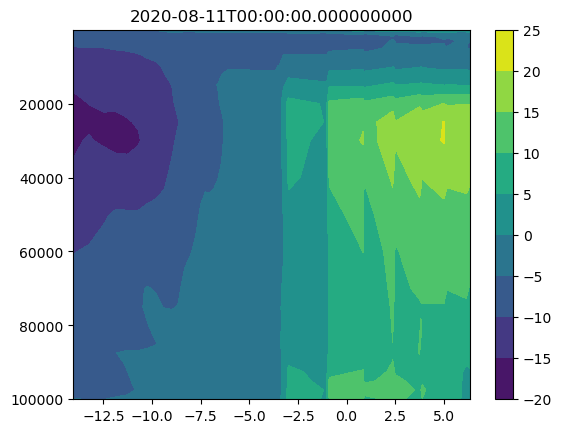

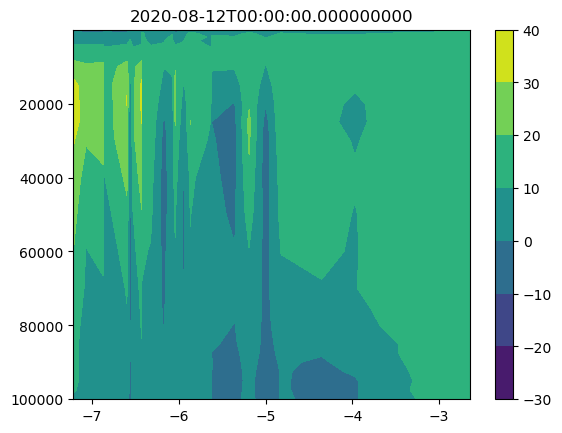

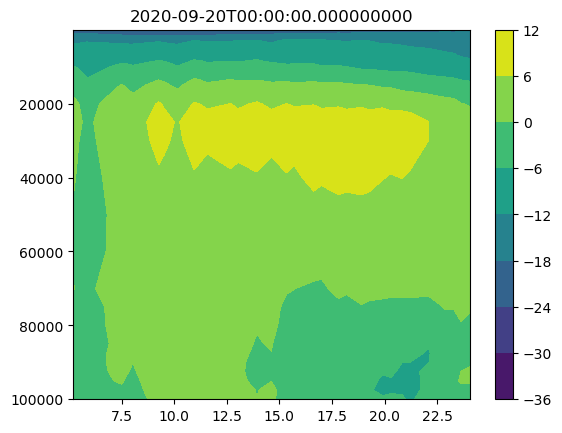

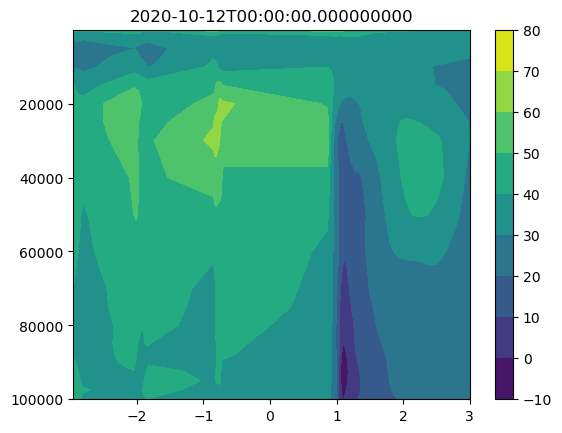

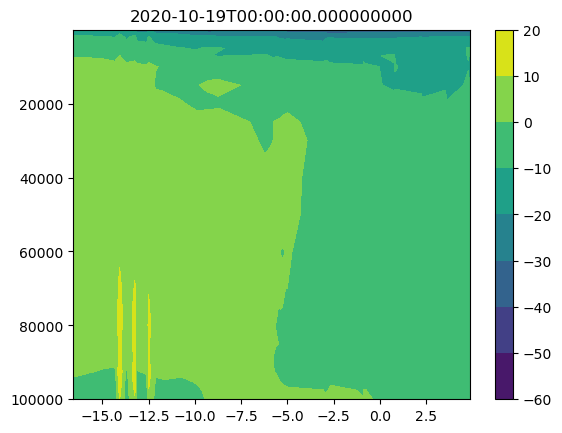

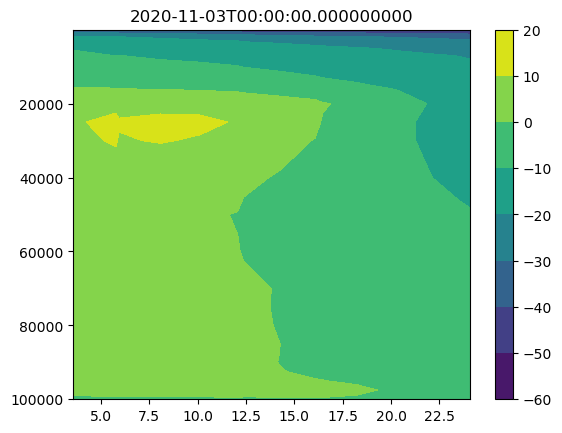

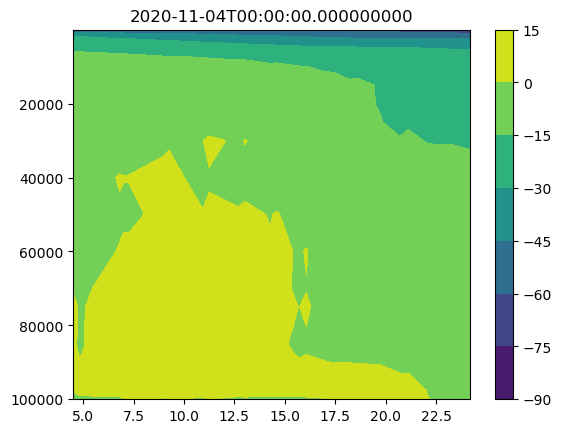

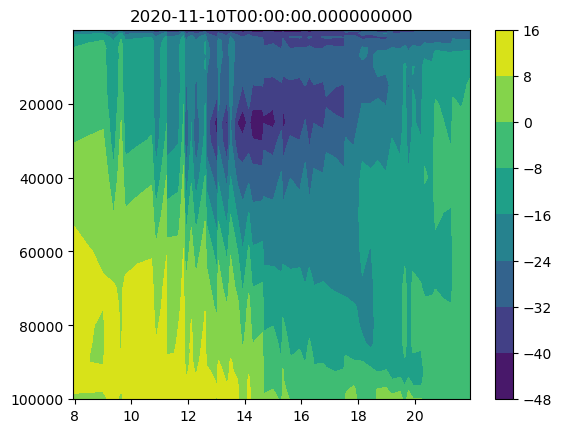

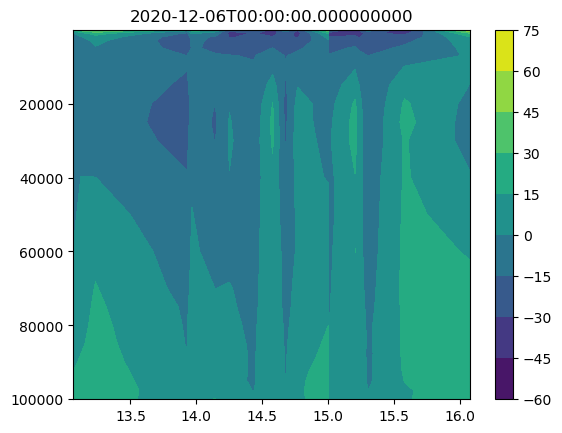

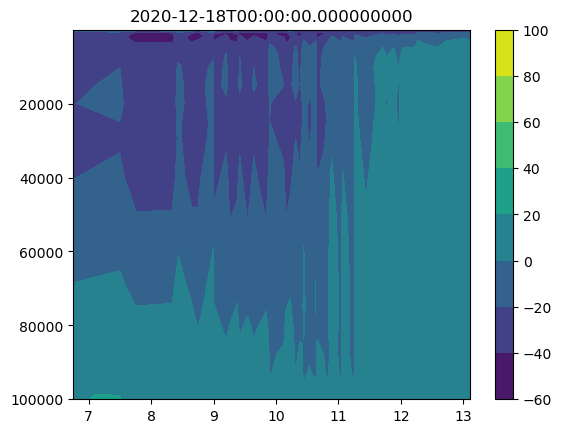

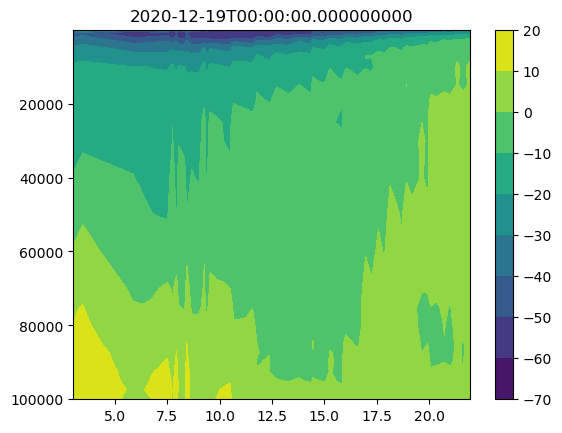

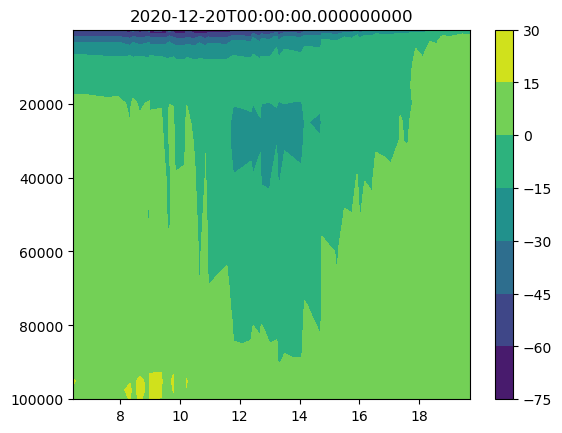

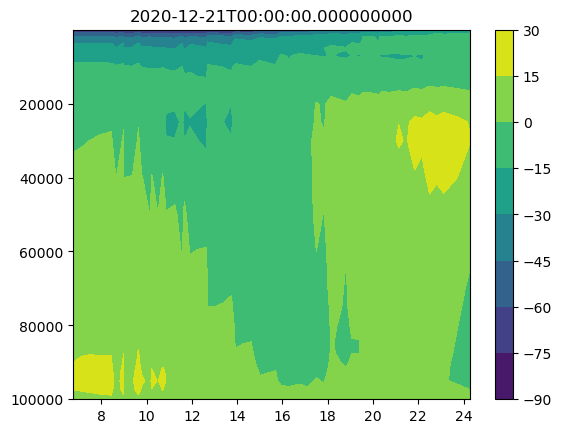

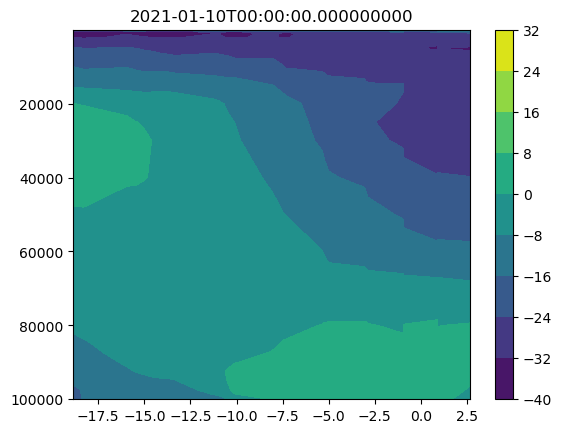

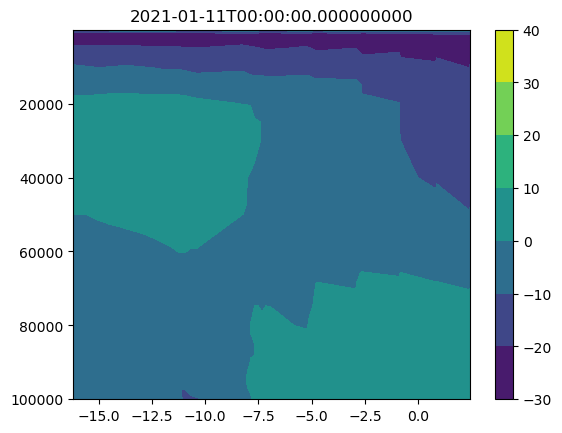

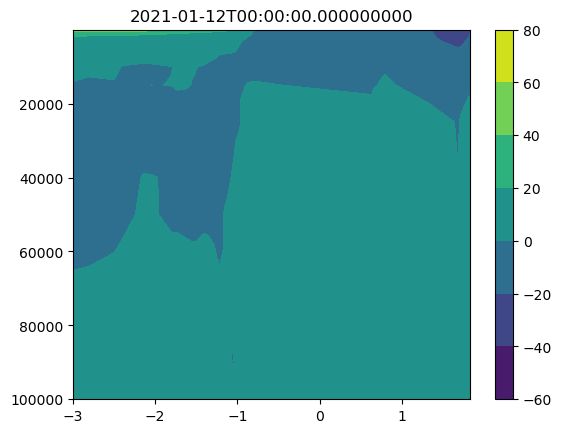

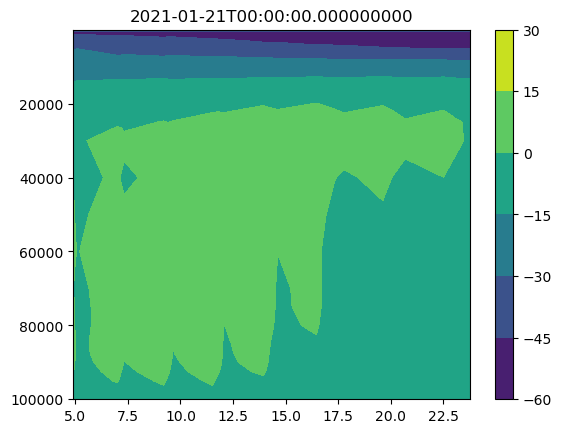

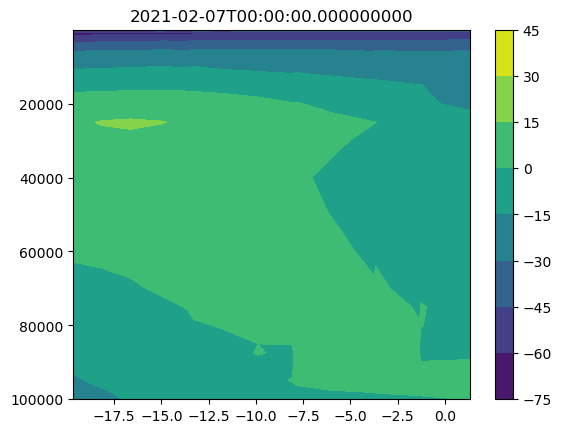

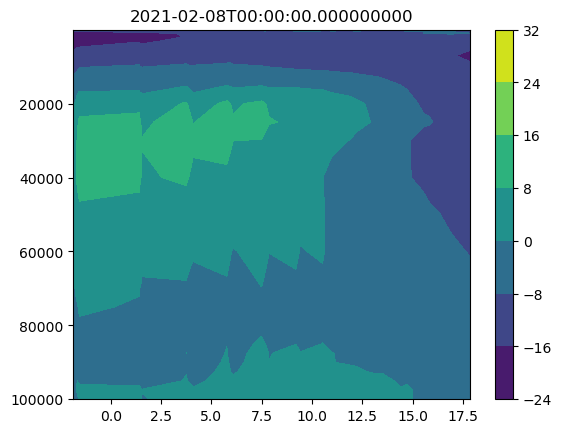

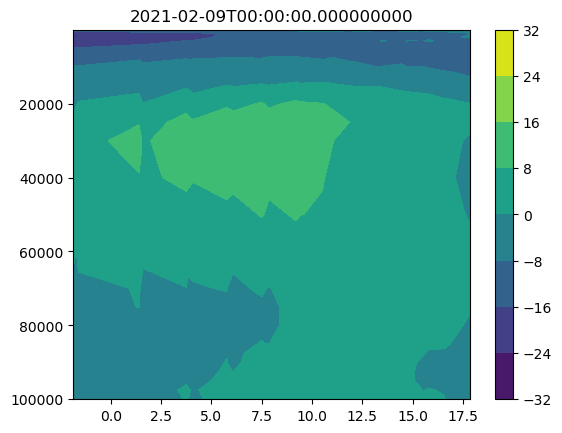

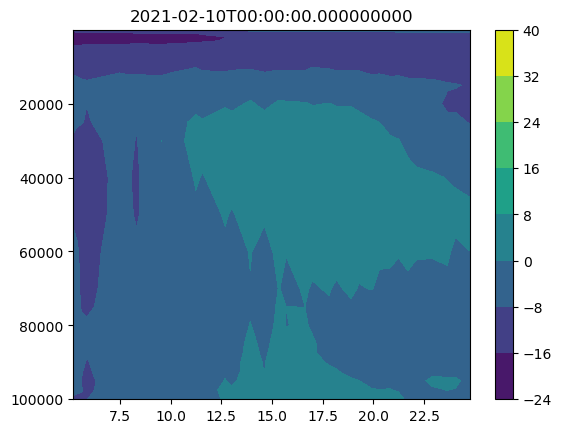

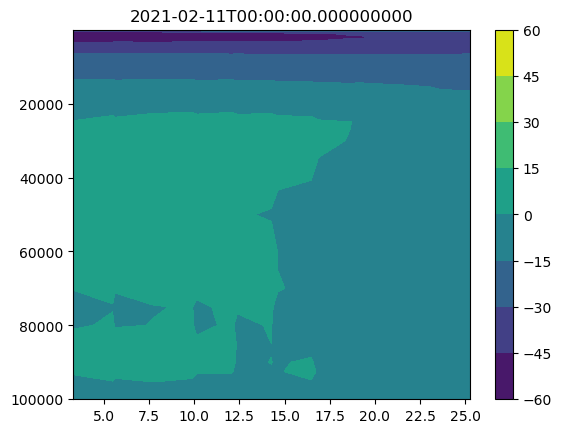

<Figure size 640x480 with 0 Axes>

In [92]:
# plot anomalous winds 

lons= np.linspace(-15, 15.0, 200)
lats = np.full_like(lons, 75.0)

pcore=85000

ds8 = cat["icon_d3hp003"](zoom=10,time_method='inst').to_dask() 
ds8 = ds8.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds.dims else ds.pipe(egh.attach_coords)
ds8['lon']=ds['lon'].where(cond=ds['lon']<180,other=ds['lon']-360)


pnts = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons, lats, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
    )

maxlon=[]
for t in ds['time'][mi_mask][:nplots]: 

    maxlon_t=ds8.prw.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").argmax()
    ucore=ds8.ua.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    vcore=ds8.va.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    maxlon.append(maxlon_t)
    
    lons_t=np.linspace(ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values-10,ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values+10,200)
    lats_t=75-(ucore.values/vcore.values)*(lons_t-ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values)
    lons_t=lons_t[((lats_t>60)&(lats_t<85))]
    lats_t=lats_t[((lats_t>60)&(lats_t<85))]

        
    pnts_t = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons_t, lats_t, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons_t), "lat": (("cell",), lats_t)},
    )

    #compute anomalous wind (deviation from core) and project onto cross-section
    u_anom=ds8.ua.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon")-ucore.values
    v_anom=ds8.va.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon")-vcore.values

    wind_proj,vector_proj=project_uv_components(u_anom,v_anom,[-ucore.values,vcore.values])
    
    m=plt.contourf(u_anom.lon,u_anom.pressure,wind_proj)
    plt.gca().invert_yaxis()
    plt.gca().set_title(t.values)
    plt.colorbar(m)
    plt.figure()
    
    

In [75]:
def project_uv_components(u, v, direction_vector):
    u = np.array(u)
    v = np.array(v)
    direction_vector = np.array(direction_vector)

    if direction_vector.shape[0] != 2:
        raise ValueError("Direction vector must have 2 elements (for 2D wind).")
    
    # Normalize the direction vector
    norm = np.linalg.norm(direction_vector)
    if norm == 0:
        raise ValueError("Direction vector must be non-zero.")
    direction_unit = direction_vector / norm

    # Scalar projection: (u * dx + v * dy)
    scalar_projection = u * direction_unit[0] + v * direction_unit[1]

    # Optional: full vector projection
    vector_projection = scalar_projection[..., np.newaxis] * direction_unit

    return scalar_projection, vector_projection

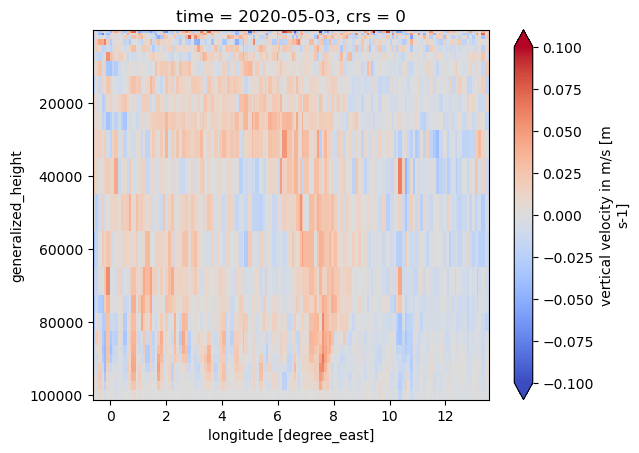

<Figure size 640x480 with 0 Axes>

In [49]:
# plot vertical velocity cross sections

lons= np.linspace(-15, 15.0, 200)
lats = np.full_like(lons, 75.0)

pcore=85000

ds8 = cat["icon_d3hp003"](zoom=10).to_dask() 
ds8 = ds8.rename_dims({'value': 'cell'}).pipe(egh.attach_coords) if 'value' in ds8.dims else ds8.pipe(egh.attach_coords)
ds8['lon']=ds8['lon'].where(cond=ds8['lon']<180,other=ds8['lon']-360)


pnts = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons, lats, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
    )

maxlon=[]
#for t in ds['time'][mi_mask][:nplots]: 
for t in ['2020-05-03T00:00:00.000000000']:

    maxlon_t=ds8.prw.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").argmax()
    ucore=ds8.ua.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    vcore=ds8.va.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    maxlon.append(maxlon_t)
    
    lons_t=np.linspace(ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values-10,ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values+10,200)
    lats_t=75-(ucore.values/vcore.values)*(lons_t-ds8.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values)
    lons_t=lons_t[((lats_t>60)&(lats_t<85))]
    lats_t=lats_t[((lats_t>60)&(lats_t<85))]
    
    
    pnts_t = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds8), lons_t, lats_t, lonlat=True, nest=get_nest(ds8)),
    dims=("cell",),
    coords={"lon": (("cell",), lons_t), "lat": (("cell",), lats_t)},
    )
    
    
    ds8.wa.isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").plot(x="lon", yincrease=False,vmin=-0.1,vmax=0.1,cmap='coolwarm')
    plt.savefig('/home/a/a270082/hackathon/wa_crosssection_20200503.png')
    plt.figure()
    
    

In [30]:
def ring2nest_index(ds, nside):
    """
        ds (xarray:Dataset): dataset with cell as dimensions
        nside (int): nside of the zoom level 
    """
    return np.array([healpy.nest2ring(nside, i) for i in ds.cell.values])

In [31]:
# compute divergence using code from Shallow circulation working group 

import pathlib
import sys
sys.path.append("../")
import toolbox as toolbox

lat_min=70

current_loc = 'EU'
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_loc]
ds = cat["icon_d3hp003"](zoom = 7,time_method='inst').to_dask()
ds = egh.attach_coords(ds)
nside = egh.get_nside(ds)
ring_index = toolbox.nest2ring_index(ds, nside)



#ds['time'] = ds['time'] - pd.Timedelta(days = 1)
ua_mi = ds['ua'].sel(time = ds['time'][mi_mask])
va_mi = ds['va'].sel(time = ds['time'][mi_mask])
wa_mi = ds.wa.sel(time = ds['time'][mi_mask])


ua_mi = ua_mi.compute()
va_mi = va_mi.compute()
wa_mi = wa_mi.compute()

conv_mi = toolbox.compute_conv(ua_mi, va_mi, ring_index, nside)

nest_index=ring2nest_index(ds,nside)

In [32]:
#
#lonse = np.linspace(0.0, 20.0, 200)
#lonsw=np.linspace(330.0,360.0,300)
#lons=np.concat([lonsw,lonse])
lons= np.linspace(-15, 15.0, 200)
lats = np.full_like(lons, 75.0)

pcore=85000

ds['lon']=ds['lon'].where(cond=ds['lon']<180,other=ds['lon']-360)

conv_mi['lon']=conv_mi['lon'].where(cond=conv_mi['lon']<180,other=conv_mi['lon']-360)

pnts = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds), lons, lats, lonlat=True, nest=get_nest(ds)),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
    )

maxlon=[]
#for nt,t in enumerate(ds['time'][mi_mask][:nplots]): 
for t in ['2020-05-03T00:00:00.000000000']:
    nt=15

    #maxlon_t=ds.prw.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").argmax()
    #ucore=ds.ua.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    #vcore=ds.va.isel(cell=pnts).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").sel(pressure=pcore)[maxlon_t]
    #maxlon.append(maxlon_t)
    
    #lons_t=np.linspace(ds.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values-10,ds.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values+10,200)
    #lats_t=75-(ucore.values/vcore.values)*(lons_t-ds.lon.isel(cell=pnts).swap_dims({"cell": "lon"}).sortby("lon")[maxlon_t].values)
    lons_t=lons_mi_t[nt]
    lats_t=lats_mi_t[nt]

        
    pnts_t = xr.DataArray(
    healpy.ang2pix(egh.get_nside(ds), lons_t, lats_t, lonlat=True, nest=get_nest(ds)),
    dims=("cell",),
    coords={"lon": (("cell",), lons_t), "lat": (("cell",), lats_t)},
    )
    
    conv_mi[:,:,nest_index].isel(cell=pnts_t).swap_dims({"cell": "lon"}).sel(time=t).sortby("lon").plot(x="lon", yincrease=False)

    #conv_mi['lat'][nest_index].isel(cell=pnts_t).swap_dims({"cell": "lon"}).sortby("lon").plot(x="lon", yincrease=False)


    
    plt.figure()
    
    

IndexError: list index out of range

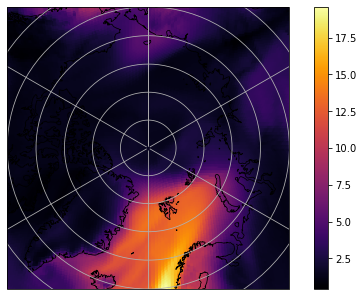

In [18]:
map_extent = [-65, -5, -10, 25]
projection = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
m=egh.healpix_show(ds8["prw"].sel(time='2020-01-17T00:00:00.000000000'), ax=ax, cmap="inferno", dpi=72);
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.gridlines()
plt.colorbar(m)

Now Plot...